<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/KAIST_SDL_2_Predictive_AI_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2. Predictive AI: CNN for Compliance Prediction**
![CNN](https://drive.google.com/uc?id=1MwNrNUYoOpqUv1UkFedcUCLRLVu9hRb9)
**Overview**:  

1) Import libraries and define parameters.  
2) Load and preprocess a dataset of images along with compliance labels.  
3) Define a Convolutional Neural Network (CNN) for predicting two compliance
values.  
4) Train and evaluate the CNN model.  
5) Visualize results.  


## 1) Import Libraries and Environment Setup

### **| Load dataset**

In [1]:
!gdown 1cG5p-tX5KV9RJyXovdr9gJnxiX0twh2k -O DDIM_Generated_images.zip
!mkdir -p DDIM_Generated_images
!unzip -q DDIM_Generated_images.zip -d DDIM_Generated_images
!ls ./DDIM_Generated_images

Downloading...
From: https://drive.google.com/uc?id=1cG5p-tX5KV9RJyXovdr9gJnxiX0twh2k
To: /content/DDIM_Generated_images.zip
100% 206k/206k [00:00<00:00, 10.7MB/s]
compliance_label.csv  inference_018.png  inference_041.png  inference_062.png  inference_082.png
inference_001.png     inference_019.png  inference_042.png  inference_063.png  inference_083.png
inference_002.png     inference_020.png  inference_043.png  inference_065.png  inference_084.png
inference_003.png     inference_023.png  inference_044.png  inference_066.png  inference_086.png
inference_004.png     inference_024.png  inference_045.png  inference_067.png  inference_087.png
inference_005.png     inference_025.png  inference_046.png  inference_068.png  inference_088.png
inference_006.png     inference_026.png  inference_048.png  inference_069.png  inference_090.png
inference_007.png     inference_027.png  inference_049.png  inference_070.png  inference_091.png
inference_008.png     inference_028.png  inference_050.png  

In [2]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import random

# Device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", device)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set a global seed for reproducibility
set_seed(1)

PyTorch version: 2.5.1+cu124
CUDA available: True
Device: cuda:0


## 2) Load and Preprocess Data
The **`ComplianceDataset`** class:
1. Reads a `compliance_label.csv` file.
2. Loads images (grayscale, `PNG` format).
3. Normalizes them to the range `[-1, 1]`.
4. Normalizes labels `(compliance1, compliance2)` to `[0, 1]`.
5. Returns `(image_tensor, label_tensor)`.

In [3]:
class ComplianceDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = data_dir
        # CSV file path
        csv_path = os.path.join(data_dir, 'compliance_label.csv')

        self.indices = []
        self.labels = []  # Will store (comp1, comp2)

        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader)  # Skip header
            for row in reader:
                index = int(row[0])
                comp1 = float(row[1])
                comp2 = float(row[2])
                self.indices.append(index)
                self.labels.append([comp1, comp2])

        self.labels = np.array(self.labels)

        # Normalize labels to [0, 1]
        self.labels_min = self.labels.min(axis=0)
        self.labels_max = self.labels.max(axis=0)
        self.labels = (self.labels - self.labels_min) / (self.labels_max - self.labels_min)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        # Image file name: inference_XXX.png
        img_path = os.path.join(self.data_dir, f"inference_{index:03d}.png")
        image = Image.open(img_path).convert('L')  # Grayscale
        image = np.array(image, dtype=np.float32)

        # Normalize image from [0, 255] to [-1, 1]
        image_tensor = torch.from_numpy(image).unsqueeze(0)  # shape: (1, H, W)
        image_tensor = (image_tensor / 127.5) - 1.0

        # Retrieve label
        label = self.labels[idx]
        label_tensor = torch.from_numpy(label).float()  # shape: (2,)

        return image_tensor, label_tensor

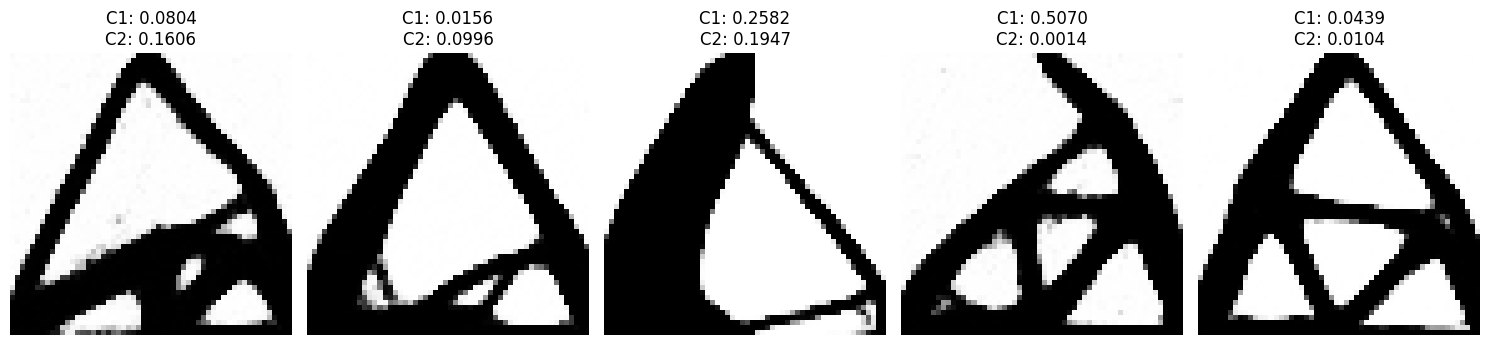

In [7]:
# Load dataset
data_dir = './DDIM_Generated_images/'
dataset = ComplianceDataset(data_dir)

# Visualize some images with compliance values
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    image, label = dataset[i]
    image = image.squeeze().numpy()  # Convert tensor to numpy array
    comp1, comp2 = label.numpy()  # Retrieve compliance values

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"C1: {comp1:.4f}\nC2: {comp2:.4f}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## 3) Define CNN Model

![CNN](https://drive.google.com/uc?id=11jjdlSmA0NxVcY2DyQeqIRZMrXyqyxC8)

1. Uses three convolution layers (with max pooling) to reduce the input `(56×56)` down to `(7×7)` with 32 channels.
2. Flattens the intermediate results and passes them through fully connected layers.
3. Outputs two values for `(compliance1, compliance2)`.


In [8]:
class ComplianceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # (compliance1, compliance2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 4) Training Loop

1. Create the dataset and split it into train & test sets.
2. Create data loaders.
3. Initialize the CNN model, criterion, optimizer, and learning rate scheduler.
4. Train for a specified number of epochs, tracking training and testing loss.
5. Save the model and a plot of the loss curves.

### **| Train / Test Functions**

In [27]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

### **| Set Up Training Configuration**

In [28]:
batch_size = 256
train_split = 0.8

# Prepare Dataset & DataLoader
full_dataset = ComplianceDataset(data_dir)
dataset_len = len(full_dataset)
train_len = int(dataset_len * train_split)
test_len = dataset_len - train_len

torch.manual_seed(1)
train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

### **| Initialize Model, Criterion, Optimizer**

In [29]:
learning_rate = 2e-3

model = ComplianceCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

### **| Training Loop**

In [30]:
epochs = 300

train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch + 1}/{epochs}]  Train Loss: {train_loss:.6f}  Test Loss: {test_loss:.6f}")
    scheduler.step()

# 5) Save Model & Loss
os.makedirs('./best_model', exist_ok=True)
torch.save(model.state_dict(), './best_model/Predictor_CNN.pth')

os.makedirs('./loss_curves', exist_ok=True)
print("Training complete. Model saved to ./best_model/Predictor_CNN.pth")


Epoch [1/300]  Train Loss: 0.048283  Test Loss: 0.036422
Epoch [2/300]  Train Loss: 0.043074  Test Loss: 0.042796
Epoch [3/300]  Train Loss: 0.042307  Test Loss: 0.037312
Epoch [4/300]  Train Loss: 0.039613  Test Loss: 0.031539
Epoch [5/300]  Train Loss: 0.038237  Test Loss: 0.029414
Epoch [6/300]  Train Loss: 0.034657  Test Loss: 0.027994
Epoch [7/300]  Train Loss: 0.031422  Test Loss: 0.021342
Epoch [8/300]  Train Loss: 0.026960  Test Loss: 0.016264
Epoch [9/300]  Train Loss: 0.024677  Test Loss: 0.016097
Epoch [10/300]  Train Loss: 0.023500  Test Loss: 0.018029
Epoch [11/300]  Train Loss: 0.023111  Test Loss: 0.017910
Epoch [12/300]  Train Loss: 0.029854  Test Loss: 0.011052
Epoch [13/300]  Train Loss: 0.017372  Test Loss: 0.017134
Epoch [14/300]  Train Loss: 0.021850  Test Loss: 0.012860
Epoch [15/300]  Train Loss: 0.018899  Test Loss: 0.010883
Epoch [16/300]  Train Loss: 0.017552  Test Loss: 0.011226
Epoch [17/300]  Train Loss: 0.018063  Test Loss: 0.011043
Epoch [18/300]  Train L

## 5) Visualize Training Results

### **| Loss Curves**

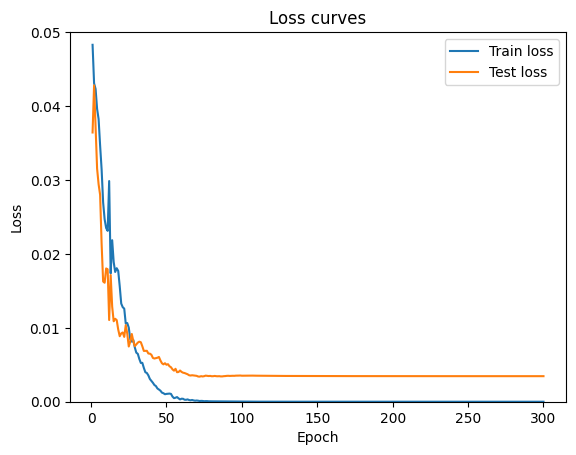

In [31]:
import math

plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.05)
plt.title('Loss curves')
plt.legend()
plt.savefig('./loss_curves/loss_curve.png')
plt.show()

### **| Evaluate Metrics: RMSE, MAPE, R^2**

In [32]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
y_true_1, y_pred_1 = [], []
y_true_2, y_pred_2 = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  # (batch, 2)
        outputs = model(images)      # (batch, 2)

        # Separate compliance1, compliance2
        y_true_1.extend(labels[:, 0].cpu().numpy())
        y_true_2.extend(labels[:, 1].cpu().numpy())
        y_pred_1.extend(outputs[:, 0].cpu().numpy())
        y_pred_2.extend(outputs[:, 1].cpu().numpy())

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

def mape(a, b):
    a, b = np.array(a), np.array(b)
    return np.mean(np.abs((a - b) / a)) * 100

y_true_1, y_pred_1 = np.array(y_true_1), np.array(y_pred_1)
y_true_2, y_pred_2 = np.array(y_true_2), np.array(y_pred_2)

compliance_min = np.array([29.07, 11.95])
compliance_max = np.array([189.90, 191.65])

y_true_1 = y_true_1 * (compliance_max[0] - compliance_min[0]) + compliance_min[0]
y_pred_1 = y_pred_1 * (compliance_max[0] - compliance_min[0]) + compliance_min[0]

y_true_2 = y_true_2 * (compliance_max[1] - compliance_min[1]) + compliance_min[1]
y_pred_2 = y_pred_2 * (compliance_max[1] - compliance_min[1]) + compliance_min[1]

rmse_1 = rmse(y_true_1, y_pred_1)
mape_1 = mape(y_true_1, y_pred_1)
r2_1 = r2_score(y_true_1, y_pred_1)

rmse_2 = rmse(y_true_2, y_pred_2)
mape_2 = mape(y_true_2, y_pred_2)
r2_2 = r2_score(y_true_2, y_pred_2)

print(f"Compliance1  RMSE: {rmse_1:.4f}, MAPE: {mape_1:.2f}%, R²: {r2_1:.4f}")
print(f"Compliance2  RMSE: {rmse_2:.4f}, MAPE: {mape_2:.2f}%, R²: {r2_2:.4f}")


Compliance1  RMSE: 9.7117, MAPE: 12.16%, R²: 0.9317
Compliance2  RMSE: 10.2689, MAPE: 17.52%, R²: 0.8308


### **| R^2 Plot (scatter of true vs. predicted)**

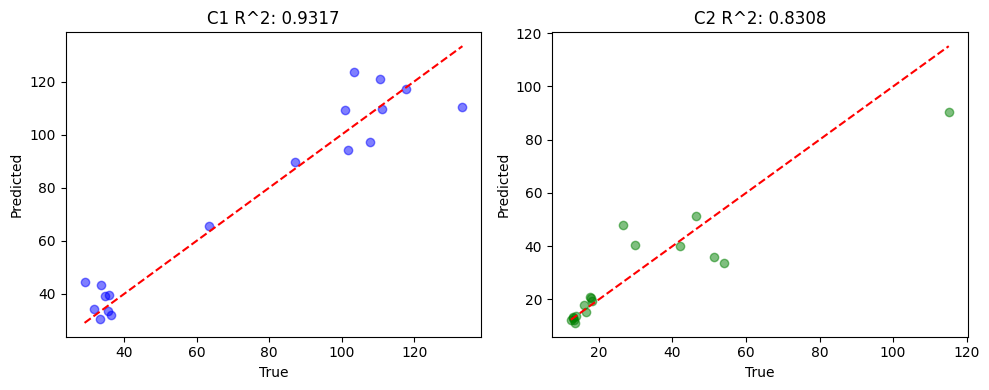

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(y_true_1, y_pred_1, c='blue', alpha=0.5, label='Compliance1')
axes[0].plot([min(y_true_1), max(y_true_1)], [min(y_true_1), max(y_true_1)], 'r--')
axes[0].set_title(f"C1 R^2: {r2_1:.4f}")
axes[0].set_xlabel("True")
axes[0].set_ylabel("Predicted")

axes[1].scatter(y_true_2, y_pred_2, c='green', alpha=0.5, label='Compliance2')
axes[1].plot([min(y_true_2), max(y_true_2)], [min(y_true_2), max(y_true_2)], 'r--')
axes[1].set_title(f"C2 R^2: {r2_2:.4f}")
axes[1].set_xlabel("True")
axes[1].set_ylabel("Predicted")

plt.tight_layout()
plt.savefig('./loss_curves/r2_scatter.png')
plt.show()
